In [1]:
%pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('../content/drive', force_remount=True)

Mounted at ../content/drive


# 바꿔야할 부분
※ 경로

In [3]:
cd ../content/drive/My Drive/졸업작품/KWS

/content/drive/My Drive/졸업작품/KWS


In [4]:
''' import libraries '''

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms  # 1 batch = (1, 784)
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

In [5]:
# torch.device
print("is there cuda? :",  torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

is there cuda? : True
cuda:0


In [8]:
# ''' 모델 불러오기 '''

# model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
# model_name = "./GRU_2layer2"
# option = 2

# device = torch.device('cpu')

# if option == 0:
#     # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
#     model_path = model_name + '_all.pt'
#     model = torch.load(model_path, map_location=device)

# elif option == 1:
#     model_path = model_name + '_state_dict.pt'
#     model = KWS_2GRU().to(device)
#     model.load_state_dict(torch.load(model_path, map_location=device))

# elif option == 2:
#     # model, optimizer 초기화
#     model = KWS_2GRU() #.to(device)
#     #optimizer = optim.Adam(model.parameters()) #, weight_decay=weight_decay)  lr=lr

#     model_path = model_name + '_ckp.tar'
#     checkpoint = torch.load(model_path, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     #last_epoch = checkpoint['last_epoch']
#     #loss = checkpoint['loss']

In [20]:
# ''' inference를 위한 모델 저장  '''  # 대박 한 2분 걸림...
# model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
# model_name = "./GRU_2layer2"
# option = 1

# if option == 0:
#     model_path = model_name + '_all.pt'
#     torch.save(model, model_path)

# elif option == 1:
#     model_path = model_name + '_state_dict.pt'
#     torch.save(model.state_dict, model_path)

# elif option == 2:
#     model_path = model_name + '_ckp.tar'
#     torch.save({
#             #'last_epoch': epochs -1,
#             'model_state_dict': model.state_dict(),
#             #'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, model_path)

In [6]:
n_mfcc = 24
Tx = 1723

In [7]:
## Multi-label GRU model 구현
# GRU layer


class KWS_2GRU(nn.Module):
    def __init__(self, p=0.0):
        super(KWS_2GRU, self).__init__()
        self.num_feature = n_mfcc
        self.hidden_size = 128
        self.conv = nn.Conv1d(in_channels=n_mfcc, out_channels=self.num_feature,
                                kernel_size=3, stride=1, padding=1) # Tx = 1723 = Ty 유지
        self.bn_num_feature = nn.BatchNorm1d(self.num_feature) # [N,C,L], what is channel?
        self.bn_Tx = nn.BatchNorm1d(Tx)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=p) 

        self.GRU1 = nn.GRU(self.num_feature, self.hidden_size,
                            num_layers=1, batch_first=True)
        self.GRU2 = nn.GRU(self.hidden_size, self.hidden_size,
                            num_layers=1, batch_first=True)
        self.linear = nn.Linear(Tx*self.hidden_size, Tx)

        '''    def myGRU(self, input_size, hidden_size, x):
        # class 내부 method는 self, 인자 필수!
         # GRU
        #     input (batch, seq_len, input_size) via batch_first
        #     hidden (num_layers * num_directions, batch, hidden_size)
        #     output (batch, seq_len, num_directions * hidden_size)

        batch_size = x.shape[0]
        #hidden = Variable(torch.zeros(1,batch_size, hidden_size)).to(device)

        # 내부에서 연산을해버리니깐, nn.GRU layer를 gpu에 올려야하네
        output, hidden = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                    num_layers=1, batch_first=True).to(device)(x) #, hidden)
        return nn.Sequential(
                    self.dropout, self.bn_Tx         
        )(output)'''

    def forward(self, x):
        # method 1 : conv1d
      
        x = torch.transpose(x, 1, 2)  # [batch_size, Tx, n_mfcc] -> [batch_size, n_mfcc, Tx]
        x = self.conv(x) # -> [batch_size, self.num_feature, Tx]
        output = nn.Sequential(
            self.bn_num_feature, self.relu, self.dropout,
        )(x)
        output = torch.transpose(output, 1, 2)  # -> [b, Tx, self.num_feature]
 
        '''
        # moethod 2 : without conv1d
        #output = x 

        #output = self.myGRU(self.num_feature, self.hidden_size, output)
        #output = self.myGRU(self.hidden_size, 1, output)
        #print(output.shape)'''
        
        output, hidden = self.GRU1(output)
        output = nn.Sequential(self.dropout, self.bn_Tx)(output)
        output, hidden = self.GRU2(output, hidden)
        output = nn.Sequential(self.dropout, self.bn_Tx, self.dropout)(output)
        output = output.view(-1, Tx*self.hidden_size)
        #print(output.shape)
        output = self.linear(output)
        # #output = nn.linear()

        return output #torch.sigmoid(output)

In [ ]:
'''hyper parameter'''
lr = 0.001
drop_prob = 0.2
weight_decay = 1e-4
model = KWS_2GRU(p=drop_prob).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr) #, weight_decay=weight_decay)
summary(model, input_size=(Tx, n_mfcc))
print("summary에 GRU 안 나오네..")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 24, 1723]           1,752
       BatchNorm1d-2             [-1, 24, 1723]              48
              ReLU-3             [-1, 24, 1723]               0
           Dropout-4             [-1, 24, 1723]               0
               GRU-5  [[-1, 1723, 128], [-1, 2, 128]]               0
           Dropout-6            [-1, 1723, 128]               0
       BatchNorm1d-7            [-1, 1723, 128]           3,446
               GRU-8  [[-1, 1723, 128], [-1, 2, 128]]               0
           Dropout-9            [-1, 1723, 128]               0
      BatchNorm1d-10            [-1, 1723, 128]           3,446
          Dropout-11            [-1, 1723, 128]               0
           Linear-12                 [-1, 1723]     379,999,035
Total params: 380,007,727
Trainable params: 380,007,727
Non-trainable params: 0
-----------

In [ ]:
batch_size = 10
## data load
X_train = np.load("./KWS_data/XY_train/train0_X.npy")  #(100, 1723, 24)
Y_train = np.load("./KWS_data/XY_train/train0_Y.npy") #(100, 1723, 1)
# X_train = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_train)) 
#=> 왜 이미 되있지?

### sigmoid -> prediction -> BCE loss

In [ ]:
# 통일성 있게 코드 짜자.
train_epoch_loss = []
train_epoch_acc = []
test_epoch_loss = []
test_epoch_acc = []

batch_size = 10
epochs = 25
print_interval = 10

for epoch in range(epochs):

    ''' Train '''
    model.train()
    train_batch_loss = []
    train_batch_acc = []
   
    npy_file = 50
    each_npy_file = 100
    train_batch_num = npy_file

    for train_idx in range(npy_file):
        root = "./KWS_data/XY_train/train"
        X_train = torch.Tensor(np.load(root + str(train_idx)+"_X.npy")) #(100, 1723, 24)
        Y_train = torch.Tensor(np.load(root + str(train_idx)+"_Y.npy")) #(100, 1723, 1)

        print("train", train_idx, "?.npy file load 완료")
        train_batch_num = int(each_npy_file/batch_size)
        for batch_idx in range(train_batch_num):
            
            mini_batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            mini_batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.float()).to(device)

            optimizer.zero_grad()
            output = model(x).squeeze() # (100, 1723, 1)->(100, 1723)
            target = target.squeeze() 
            #print(output.shape, "\n======\n", target.shape)

            loss = nn.BCEWithLogitsLoss()(output, target).to(device)
            #loss = nn.BCELoss()(output, target).to(device)

            loss.backward()    # calc gradients
            train_batch_loss.append(loss.item()/batch_size*100) # from tensor -> get value loss.item() or loss.data
            optimizer.step()   # update gradients
            
            # Accuracy computation
            # True if hypothesis>0.7 else False

            predicted = (output > 0.6).float()
            accuracy = (predicted == target).float().mean().item()/batch_size*100  # sum?
            train_batch_acc.append(accuracy)

        train_epoch_loss.append(np.sum(train_batch_loss)/train_batch_num)
        train_epoch_acc.append(np.sum(train_batch_acc)/train_batch_num)

        # data 100개마다 출력해보기
        print('epoch: {}\tdata num: {}\tLoss: {:.3f}%\tAccuracy: {:.3f}%'.format(
        epoch, (train_idx+1)*100, train_batch_loss[-1], train_batch_acc[-1]))

        probabilty = output.detach().cpu().numpy()

        fig = plt.figure(figsize=(8,4))
        ax1 = fig.add_subplot(1, 2, 1)
        plt.plot(probabilty[0, :], 'b')
        plt.plot(target[0, :].cpu(), 'r')
        ax1.set(ylabel="probability", xlabel='Tx')

        ax2 = fig.add_subplot(1, 2, 2)
        plt.plot(probabilty[9, :], 'b')
        plt.plot(target[9, :].cpu(), 'r')
        ax2.set(ylabel="probability", xlabel='Tx')

        plt.show()

    print("============epoch{}=============".format(epoch))  
    print("train_epoch_loss", train_epoch_loss)
    print("test_epoch_loss", test_epoch_loss)


    # ''' Test '''
    # model.eval()
    # test_batch_loss = []
    # test_batch_acc = []

    

Output hidden; open in https://colab.research.google.com to view.

In [17]:
''' inference를 위한 모델 저장  '''  # 대박 한 2분 걸림...
model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./GRU_2layer_절약"
option = 2

if option == 0:
    model_path = model_name + '_all.pt'
    torch.save(model, model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    torch.save(model.state_dict, model_path)

elif option == 2:
    model_path = model_name + '_ckp.tar'
    torch.save({
            #'last_epoch': epochs -1,
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_path)

## After KWS training

In [18]:

''' 모델 불러오기 '''

model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./GRU_2layer_절약"
option = 2

device = torch.device('cpu')

if option == 0:
    # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
    model_path = model_name + '_all.pt'
    model = torch.load(model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    model = CNN_Net()
    model.load_state_dict(torch.load(model_path))

elif option == 2:
    # model, optimizer 초기화
    model = KWS_2GRU()  #.to(device)
    #optimizer = optim.Adam(model.parameters()) #, weight_decay=weight_decay)  lr=lr

    model_path = model_name + '_ckp.tar'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #last_epoch = checkpoint['last_epoch']
    #loss = checkpoint['loss']

In [9]:
pip install pydub

In [10]:
import IPython.display as ipd
import librosa
from pydub import AudioSegment

In [11]:
def feature_mfcc(RECORD_FILE_NAME):

    # 조정할 수 있는 건 다 적어보자.
    hop_length= 128
    n_mfcc = 24
    # n_mels = 20
    n_fft = 101
    fmin = 0
    fmax = None
    # sr = 16000

    # sr = 22050 = bitrate/2 -> Q. bitrate 와 어떤 관계?
    # Generate mfccs from a time series
    # t초당 sig.shape = (t*sr,)
    sig, sr = librosa.load(RECORD_FILE_NAME)  # , sr=sr

    # 만약, sr=16000, mfcc.shape = (n_mfcc,1251)
    #       sr=(default)22050, mfcc.shape = (n_mfcc, 1723)


    mfcc = librosa.feature.mfcc(y=sig, sr=sr, hop_length=hop_length, fmin=fmin, fmax = fmax,
                                  n_fft= n_fft, n_mfcc=n_mfcc)
    print("here", mfcc.shape)

    return mfcc

In [21]:
RECORD_FILE_PATH = './10s_one_stop_two.wav' # 10s_one_stop_two.wav  # 10s_stop_one.wav
ipd.Audio(RECORD_FILE_PATH)

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


here (24, 1723)
torch.Size([1723])


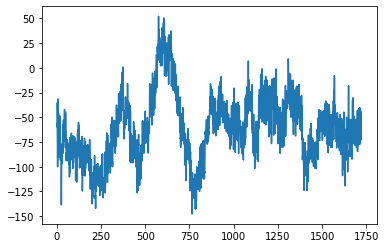

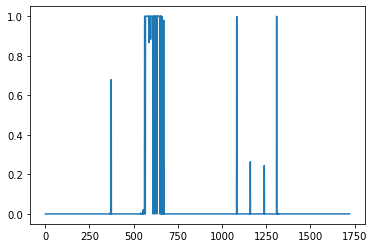

In [19]:
mfcc = feature_mfcc(RECORD_FILE_PATH)  # [n_mfcc, Tx]
mfcc = np.transpose(mfcc)# [Tx, n_mfcc]
mfcc = np.expand_dims(mfcc, 0)  #[1, Tx, n_mfcc]
mfcc = torch.Tensor(mfcc).to(device)
prediction = model(mfcc).squeeze()
print(prediction.shape)

result = prediction.detach().cpu().numpy()
sig_result = torch.sigmoid(prediction).detach().cpu().numpy()
#print(result)
plt.plot(result)
plt.figure()
plt.plot(sig_result)

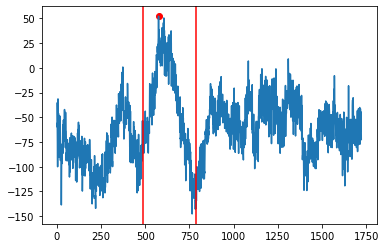

time:  2814 ~ 4556


In [27]:

peak_y = np.max(result)
peak_x = np.where(result == peak_y)[0][0]

# get Extraction duration
T_y = 1723
mark_length = 300  # 172로 하면, Tight 하긴한데 피아노 배경 Activate 말고 학습 굿
left_step = int(mark_length * 0.3)
left_x = peak_x - left_step if peak_x - left_step > 0 else 0
right_x = left_x + mark_length

scatter_x = [peak_x]  # , peak_x, left_x, right_x
scatter_y = [peak_y]  # , 0, 0, 0
plt.figure()
#plt.ylim([0, 1.1])
plt.plot(result)
plt.scatter(scatter_x, scatter_y, c=['r'])  # , 'r', 'g', 'g'
plt.axvline(x=left_x, color='r', linestyle='-')
plt.axvline(x=right_x, color='r', linestyle='-')
plt.show()

# pyaudio peak and restore
# pydub does thing in milliseconds
segment_left_t = int(left_x * 10000.0 / T_y)  # + 2500
segment_right_t = int(right_x * 10000.0 / T_y)  # + 2500


print("time: ", segment_left_t, "~", segment_right_t)

sig = AudioSegment.from_wav(RECORD_FILE_PATH)

ex_Keyword = sig[segment_left_t : segment_right_t + 1]

ex_FILE_PATH = "./extraction.wav"
file_handle = ex_Keyword.export(ex_FILE_PATH, format="wav")


In [23]:
import librosa.display

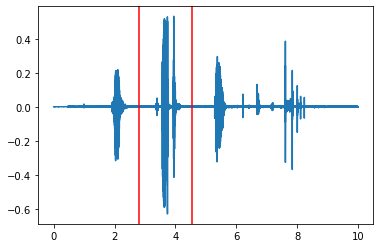

In [36]:
sig, sr = librosa.load(RECORD_FILE_PATH)
#librosa.display.waveplot(sig, sr=sr)
Time = np.linspace(0, len(sig) / sr, num=len(sig))
plt.plot(Time, sig)
#plt.scatter(scatter_x, scatter_y, c=['r'])  # , 'r', 'g', 'g'
plt.axvline(x=segment_left_t/1000, color='r', linestyle='-')
plt.axvline(x=segment_right_t/1000, color='r', linestyle='-')
plt.show()

In [ ]:
ipd.Audio(ex_FILE_PATH)